In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras.backend as K
import pandas as pd
import numpy as np
import itertools
import time
from itertools import cycle
import datetime 
import matplotlib.ticker as ticker

plt.rc('font', size=15)      
plt.rc('axes', labelsize=15)  
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('legend', fontsize=15) 
plt.rc('figure', titlesize=15)

SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [2]:
# read time series data
data = pd.read_csv('data/time_series_60min_singleindex.csv')
weather = pd.read_csv('data/weather_data.csv')

In [3]:
data.describe()

,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,BE_wind_offshore_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
count,50400.000000,50400.000000,32845.000000,50339.000000,50352.000000,50400.000000,50376.000000,50385.000000,46466.000000,46466.000000,...,50340.000000,50398.000000,50391.000000,50379.000000,5.037300e+04,50398.000000,50010.000000,9679.000000,25635.000000,25413.000000
mean,7070.148631,7039.848552,33.934663,135.280121,729.653261,9808.383929,9759.323567,393.402158,779.920474,433.482914,...,1462.742614,1465.434762,31.886199,0.546785,3.336826e+03,3288.454423,60.563224,0.684807,17006.680807,17290.802306
std,1400.263167,1355.382837,14.944863,198.955378,692.002497,1393.548610,1380.214097,621.803385,665.931016,400.823333,...,262.562188,260.132266,47.972831,0.726016,9.678832e+03,457.612965,91.983827,2.531283,2776.794985,2741.479932
min,664.000000,3739.000000,-76.000000,0.000000,0.000000,6245.000000,6522.000000,0.000000,1.090000,0.000000,...,24.240000,753.000000,0.000000,0.000000,1.830000e+03,2040.000000,0.000000,0.000000,10905.000000,11450.000000
25%,5941.000000,5941.000000,25.000000,0.000000,162.000000,8706.000000,8671.000000,0.000000,245.532500,103.652500,...,1252.360000,1253.000000,0.040000,0.000000,2.942000e+03,2940.000000,0.000000,0.000000,15048.000000,15420.000000
50%,7032.000000,7018.000000,33.000000,18.000000,493.000000,9809.000000,9757.000000,10.670000,571.515000,317.345000,...,1463.970000,1474.000000,1.850000,0.270000,3.295000e+03,3300.000000,2.900000,0.300000,16678.000000,16905.000000
75%,8079.000000,7986.000000,42.000000,224.000000,1141.000000,10852.000000,10813.250000,596.400000,1171.482500,650.000000,...,1658.702500,1662.000000,52.530000,0.790000,3.600000e+03,3600.000000,97.900000,0.800000,18862.000000,19173.000000
max,10803.000000,11608.000000,187.000000,1166.000000,2969.000000,13670.000000,13454.000000,3281.400000,3252.680000,1944.160000,...,2402.250000,2206.000000,717.820000,4.670000,2.170811e+06,4520.000000,387.200000,36.500000,24684.000000,24739.000000


In [4]:
data = data[['utc_timestamp','GB_UKM_solar_generation_actual']]

data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data['utc_timestamp'] = data['utc_timestamp'] .dt.strftime('%Y-%m-%d %H:%M:%S')
data = data[(data['utc_timestamp'] >= '2015-01-01 00:00:00') & (data['utc_timestamp'] < '2020-01-01 00:00:00')]
weather['utc_timestamp'] = pd.to_datetime(weather['utc_timestamp'])
weather['utc_timestamp'] = weather['utc_timestamp'] .dt.strftime('%Y-%m-%d %H:%M:%S')
weather = weather[['utc_timestamp', 'GB_temperature', 'GB_radiation_direct_horizontal', 'GB_radiation_diffuse_horizontal']]
weather = weather[(weather['utc_timestamp'] >= '2015-01-01 00:00:00') & (weather['utc_timestamp'] < '2020-01-01 00:00:00')]

In [5]:
data.loc[data[(data['GB_UKM_solar_generation_actual'] < 0)]['GB_UKM_solar_generation_actual'].index, 'GB_UKM_solar_generation_actual'] = np.nan

In [6]:
data = data[['utc_timestamp','GB_UKM_solar_generation_actual']]

data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data['utc_timestamp'] = data['utc_timestamp'] .dt.strftime('%Y-%m-%d %H:%M:%S')
data['date'] = data['utc_timestamp'].str.split(' ').str[0]
data['hour'] = data['utc_timestamp'].str.split(' ').str[1].str.split(':').str[0].astype(int)
data['year'] = data['date'].str.split('-').str[0].astype(int)
data['month'] = data['date'].str.split('-').str[1].astype(int)
data['day'] = data['date'].str.split('-').str[2].astype(int)
data.interpolate(method='values',order = 2,inplace=True, limit_direction='both')

data = data[(data['utc_timestamp'] >= '2015-01-01 00:00:00') & (data['utc_timestamp'] < '2020-01-01 00:00:00')]

In [7]:
weather['utc_timestamp'] = pd.to_datetime(weather['utc_timestamp'])
weather['utc_timestamp'] = weather['utc_timestamp'] .dt.strftime('%Y-%m-%d %H:%M:%S')
weather = weather[['utc_timestamp', 'GB_temperature', 'GB_radiation_direct_horizontal', 'GB_radiation_diffuse_horizontal']]
weather = weather[(weather['utc_timestamp'] >= '2015-01-01 00:00:00') & (weather['utc_timestamp'] < '2020-01-01 00:00:00')]

In [8]:
df = weather.merge(data, left_on='utc_timestamp', right_on='utc_timestamp', how='outer')
df = df[['year','GB_temperature', 'GB_radiation_direct_horizontal', 'GB_radiation_diffuse_horizontal', 'GB_UKM_solar_generation_actual']]
df_train = df[~(df['year'] == 2019)].reset_index(drop=True)
df_test = df[(df['year'] == 2019)].reset_index(drop=True)
df_train = df_train[['GB_temperature', 'GB_radiation_direct_horizontal', 'GB_radiation_diffuse_horizontal', 'GB_UKM_solar_generation_actual']]
df_test = df_test[['GB_temperature', 'GB_radiation_direct_horizontal', 'GB_radiation_diffuse_horizontal', 'GB_UKM_solar_generation_actual']]

In [32]:
linestyle_cycler = cycle(['-','--',':','-.'])
palette = 'summer'
plt.set_cmap(palette)
cmap = plt.get_cmap(palette)

df_visulaization = weather.merge(data, left_on='utc_timestamp', right_on='utc_timestamp', how='outer')

<Figure size 432x288 with 0 Axes>

In [33]:
df_visulaization.interpolate(method='values',order = 2,inplace=True, limit_direction='both')

In [34]:
df_visulaization.set_index('utc_timestamp', inplace=True)

In [35]:
df_visulaization.index = pd.to_datetime(df_visulaization.index, utc=True)
df_visulaization = df_visulaization[['GB_UKM_solar_generation_actual']]

In [36]:
def discrete_cmap(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

C:\Users\kepco\anaconda3\envs\IRP\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  


Text(0, 0.5, 'Actual')

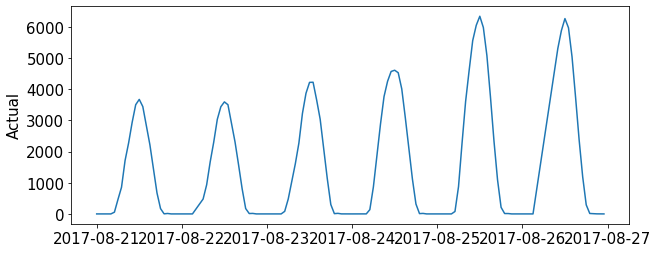

In [37]:
cmap_aux = discrete_cmap(6+1, palette) 
fig, ax = plt.subplots(1,1, figsize=(10,4))
for y in [2017]:
    init_date = datetime.datetime(year=y,month=8,day=21, hour=0, minute=0)
    end_date = datetime.datetime(year=y,month=8,day=26, hour=23, minute=59)
    s_aux = df_visulaization.loc[init_date:end_date]
    ax.plot(s_aux, label=str(y))
ax.set_ylabel('Actual')

C:\Users\kepco\anaconda3\envs\IRP\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  


Text(0, 0.5, 'Actual')

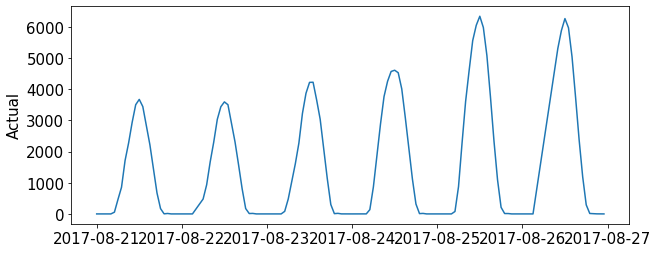

In [38]:
cmap_aux = discrete_cmap(6+1, palette) 
fig, ax = plt.subplots(1,1, figsize=(10,4))
for y in [2017]:
    init_date = datetime.datetime(year=y,month=8,day=21, hour=0, minute=0)
    end_date = datetime.datetime(year=y,month=8,day=26, hour=23, minute=59)
    s_aux = df_visulaization.loc[init_date:end_date]
    ax.plot(s_aux, label=str(y))
ax.set_ylabel('Actual')

C:\Users\kepco\anaconda3\envs\IRP\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  


[Text(0.0, 0, 'January'),
 Text(31.0, 0, 'Feb.'),
 Text(59.0, 0, 'March'),
 Text(90.0, 0, 'April'),
 Text(120.0, 0, 'May'),
 Text(151.0, 0, 'June'),
 Text(181.0, 0, 'July'),
 Text(212.0, 0, 'August'),
 Text(243.0, 0, 'Sep.'),
 Text(273.0, 0, 'October'),
 Text(304.0, 0, 'Nov.'),
 Text(334.0, 0, 'December')]

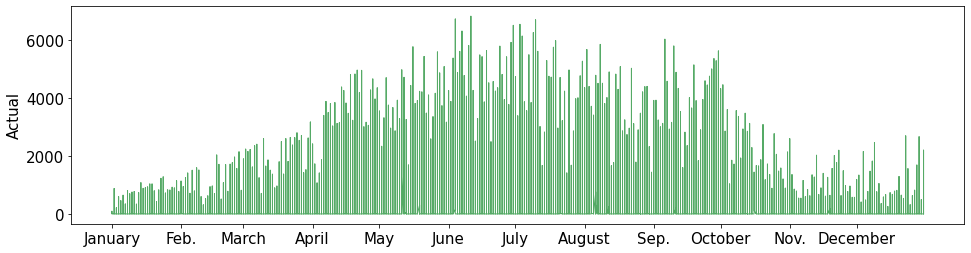

In [39]:
cmap_aux = discrete_cmap(6+1, palette) 
fig, ax = plt.subplots(1,1, figsize=(16,4))
for y in [2015]:
    init_date = datetime.datetime(year=y,month=1,day=1, hour=0, minute=0)
    end_date = datetime.datetime(year=y,month=12,day=31, hour=23, minute=59)
    s_aux = df_visulaization.loc[init_date:end_date]
    s_aux.index = s_aux.index.map(lambda x : x.strftime('%d %B'))
    ax.plot(s_aux, alpha=1., label=str(y), color=cmap_aux(2), linewidth=1)
ax.set_ylabel('Actual')
ax.set_xticks(['01 January', '01 February', '01 March', '01 April', '01 May', '01 June', '01 July', '01 August', '01 September', '01 October', '01 November', '01 December'])
ax.set_xticklabels(['January', 'Feb.', 'March', 'April', 'May', 'June', 'July', 'August', 'Sep.', 'October', 'Nov.', 'December'])

C:\Users\kepco\anaconda3\envs\IRP\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  


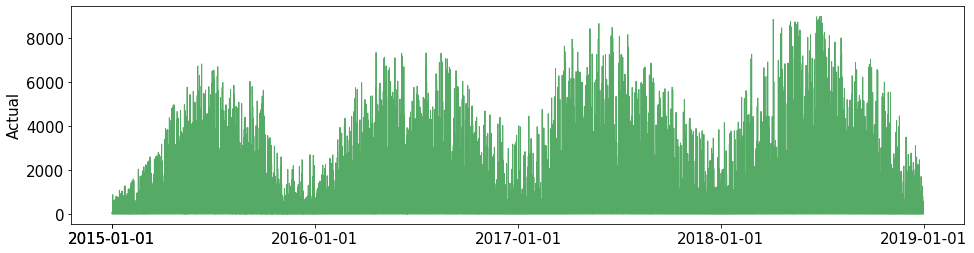

In [40]:
cmap_aux = discrete_cmap(6+1, palette) 
fig, ax = plt.subplots(1,1, figsize=(16,4))
for y in range(2015,2019):
    init_date = datetime.datetime(year=y,month=1,day=1, hour=0, minute=0)
    end_date = datetime.datetime(year=y,month=12,day=31, hour=23, minute=59)
    s_aux = df_visulaization.loc[init_date:end_date]
    ax.plot(s_aux, alpha=1., label=str(y), color=cmap_aux(2), linewidth=1)
ax.set_ylabel('Actual')
ax.set_xticks(['2015', '2015', '2016', '2017', '2018', '2019'])

C:\Users\kepco\anaconda3\envs\IRP\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  import sys
C:\Users\kepco\anaconda3\envs\IRP\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  import sys
C:\Users\kepco\anaconda3\envs\IRP\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  import sys
C:\Users\kepco\anaconda3\envs\IRP\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and 

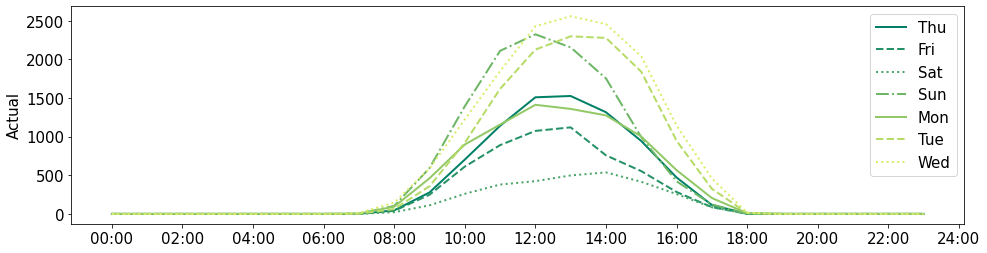

In [41]:
cmap_aux = discrete_cmap(7+1, palette)
linestyle_cycler = cycle(['-','--',':','-.'])
fig, ax = plt.subplots(1,1, figsize=(16,4))
for i in range(7):
    init_date = datetime.datetime(year=2016,month=2,day=i+4, hour=0, minute=0 )
    end_date = datetime.datetime(year=2016,month=2,day=i+4, hour=23, minute=59)
    s_aux = df_visulaization.loc[init_date:end_date]
    s_aux.index = s_aux.index.map(lambda x : x.strftime('%H:%M'))
    ax.plot(s_aux, alpha=1, label=(init_date.strftime('%a')), linestyle=next(linestyle_cycler), color=cmap_aux(i), linewidth=2)    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(len(s_aux)/12))
ax.set_xticks(['00:00', '02:00', '04:00', '06:00', '08:00', '10:00', '12:00', '14:00', '16:00',
              '18:00','20:00','22:00','24:00'])
ax.set_ylabel('Actual')
ax.legend()